# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Julio Pérez Cabeza</mark>

# <font color='blue'>**Ejercicio  3: Transfer Learning y fine-tuning con ResNet50 en el SPR X-Ray Age Prediction Challenge (3.5 points)**
<font color='blue'>En este ejercicio trabajaremos con el _SPR X-Ray Age Prediction Challenge_ de Kaggle (https://www.kaggle.com/competitions/spr-x-ray-age/data). Este dataset consta de $10 702$ radiografías de tórax, y el objetivo es predecir la edad de la persona a partir de la imagen de la radiografía. En esta ocasión, se emplearán $6 702$ imágenes para entrenamiento y $4 000$ para test. Las edades oscilan entre los 18 y los 89 años. Para facilitar el trabajo al alumnado se proporciona una versión procesada de los datos (con resolución $224\times224$, en lugar de $1024\times1024$, y empleando solo ejemplos para los cuales se tiene salida deseada (dado que, al tratarse de una challenge de kaggle, el conjunto de test está disponible pero sin etiquetar)). Estos datos se pueden acceder desde: https://drive.google.com/drive/folders/1hCWfTLs1w0h5kObl6NEIhEtH5VDmmCnj?usp=sharing (se debe emplear una cuenta de la UGR para acceder a dicha URL, y la información allí contenida (directorio `spr-x-ray-age`) se debe incluir en la carpeta `Colab Notebooks`).

<font color='blue'>Se debe emplear un $20\%$ de los datos de entrenamiento para validación, y el rendimiento debe ser evaluado, como mínimo, por medio de $MSE$, $MAE$ y $R^2$ _(coefficient of determination) score_. Se deben justificar las decisiones tomadas, como la elección de la función de pérdida. Del mismo modo, es necesario hacer un `summary()` de las arquitecturas empleadas en cada apartado, indicando qué parámetros/capas/bloques son entrenables y cuáles no lo son (es decir, en cada apartado es imprescindible destacar claramente qué arquitectura exacta se está utilizando, así como qué pesos se están entrenando y cuáles se están congelando).

<font color='blue'>Usaremos un modelo ResNet50 pre-entrenado en ImageNet, y tendremos que realizar los siguientes experimentos en relación a la estrategia de entrenamiento:

<font color='blue'>1. Partimos de ResNet50, adaptamos la cabecera (sustituyendo la cabecera anterior por *una única fully-connected* con el número de neuronas de salida adecuado), y reentrenamos (_from scratch_) la red entera para este nuevo problema. Es decir, partimos de pesos aleatorios para resolver este problema de regresión.

<font color='blue'>2. Partimos de ResNet50, adaptamos la cabecera (empleando la misma del apartado anterior), y entrenamos solo la cabecera incorporada. Es decir, ResNet50 se usa como un mero extractor de características, y los pesos que se entrenan son los de la nueva capa incorporada (manteniendo fijos/congelados todos los demás).  

<font color='blue'>3. Partimos de ResNet50, dejamos que fastai incorpore su cabecera por defecto (véase https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw o https://docs.fast.ai/vision.learner.html#head-and-model), y entrenamos solo la cabecera incorporada. Es decir, de nuevo, ResNet50 se usa como extractor de características, y los pesos que se entrenan son los de las nuevas capas incorporadas

<font color='blue'>4. Partimos de ResNet50, adaptamos la cabecera (puede ser la del apartado 3.2 o la del 3.3), y hacemos un ajuste fino de toda la red partiendo de los pesos de ResNet50 (preentrenada en ImageNet).



<font color='blue'>Es importante remarcar que estamos intentando resolver un problema de regresión por medio de la reutilización de un modelo pre-entrenado en un problema de clasificación (ImageNet). ¿Tiene sentido hacerlo? ¿Por qué nos sirven pesos entrenados en clasificación para un problema de regresión? ¿No son, acaso, problemáticas muy diferentes?

Pasamos ahora a la documentación de la práctica sobre **Transfer Learning**, donde el primer paso, como casi siempre, es la descripción del dataset. Como ya se nos da hecho, podemos comentarlo por encima y pasar directamente a la implementación.

**¿Qué entendemos por Transfer Learning?**

Cuando queremos tener acceso a conocimiento sobre cierta área, podemos recurrir a diversas fuentes. Podemos consultar en internet, preguntar a expertos sobre el tema, etc. Pues bien, para nosotros, una red entrenada va a ser nuestra fuente.

Partimos de una red preentrenada y **transferimos** su conocimiento a nuestro problema en particular. De esta manera, usamos conocimiento previo para adaptarlo a nuestra tarea específica. Para ello, basta con hacer ciertos cambios (que explicaremos más tarde) a la red y estará lista para servir en un nuevo problema.

<center><img src = https://www.topbots.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg height = '200'></center>

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://www.topbots.com/transfer-learning-in-nlp/

De nuevo, como se ha hecho en las partes anteriores de la práctica, se trabajará con `DataBlock` y `DataLoader`, que son dos objetos muy importantes a la hora de usar **FastAI**. Nos permiten acceder y recorrer el dataset a usar para su posterior entrenamiento y validación.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
# defining the paths to images and labels
train_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train'
test_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/test'
csv_path = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/All_labels.csv'

In [ ]:
if os.path.exists(csv_path):
    print("CSV File exists!")
    # reading the labels dataframe
    df = pd.read_csv(csv_path, dtype=float, index_col=0)
    print(f'Dataframe shape: {df.shape}')
else:
    print("File does not exist.")

CSV File exists!
Dataframe shape: (10702, 1)


In [ ]:
# defining the dataset paths
train_path = Path(train_folder)
test_path = Path(test_folder)

# reading the folders looking for images
train_files = get_image_files(train_path)
test_files = sorted(get_image_files(test_path))

print(f'{len(train_files)} files were found for training and {len(test_files)} files were found for test')

6702 files were found for training and 4000 files were found for test


<img src = https://cdn.pixabay.com/photo/2016/03/31/14/37/check-mark-1292787_1280.png height = '20' width = '20'> Coincide con lo descrito en el enunciado, trabajaremos con 6072 imágenes para entrenamiento y 4000 para test.

Age varies from 18.0 to 89.0



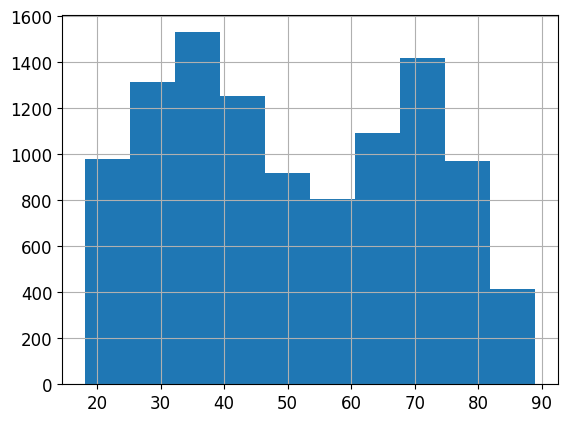

In [ ]:
print(f'Age varies from {df.age.min()} to {df.age.max()}\n')
_=df.age.hist()

Como se nos indica en el enunciado, trabajaremos con un conjunto de datos (imágenes) que representan radiografías de tórax. Nuestro objetivo será predecir la edad que tiene la persona correspondiente a la radiografía. Para ello, haremos uso de las etiquetas que identifican a cada una de nuestras muestras.

En un análisis exploratorio de los datos, podemos recorrer todas las etiquetas y ver en un histograma la frecuencia con que aparece cierta edad en el conjunto de etiquetas del dataset. Vemos que las edades más frecuentes son entre 30 y 40 años y en torno a los 70. Conforme nos acercamos a edades mucho más avanzadas vamos teniendo menos datos.

In [ ]:
# function used to retun the label from an image
def label_func(file):
    # takes the file's base name w/o the extension
    basename = int(os.path.basename(str(file)).split('.')[0])

    # searches for the label
    label = int(df.age[basename])

    return label

Definimos ahora nuestro **DataLoader**:

* `blocks`: Especifica el tipo de dato que estamos pasando. Al usar (ImageBlock,CategoryBlock), estamos diciendo que los datos son de tipo imagen y una categoría, o clase, asociada.
* `get_items`: Indica de donde obtener los datos. Haremos uso de `get_image_files`, que se usa pasándole un path y devuelve la lista de imágenes.
* `splitter`: Controla cómo se crea el conjunto de validación. Aquí usaremos los parámetros de RandomSplitter, para hacer que el conjunto de validación sea del $20\%$.

* `get_y`: Este parámetro especifica cuáles serán las etiquetas a usar para nuestros datos. Llamamos a nuestra función creada más arriba label_func para obtener las etiquetas.

Como son imágenes muy parecidas entre ellas, con rangos de grises muy similares, **no utilizaremos normalización** para llamar al dataloader. Bajo mi punto de vista, no sería necesario hacerlo, a menos que observemos resultados muy poco satisfactorios.

Como también se comentaba en la anterior parte de la práctica, usaremos un **Batch Size** de 32, pues es un valor razonable y potencia de 2. También es susceptible a cambios si observamos tiempos de ejecución muy altos o si vemos un rendimiento por debajo de lo esperado.

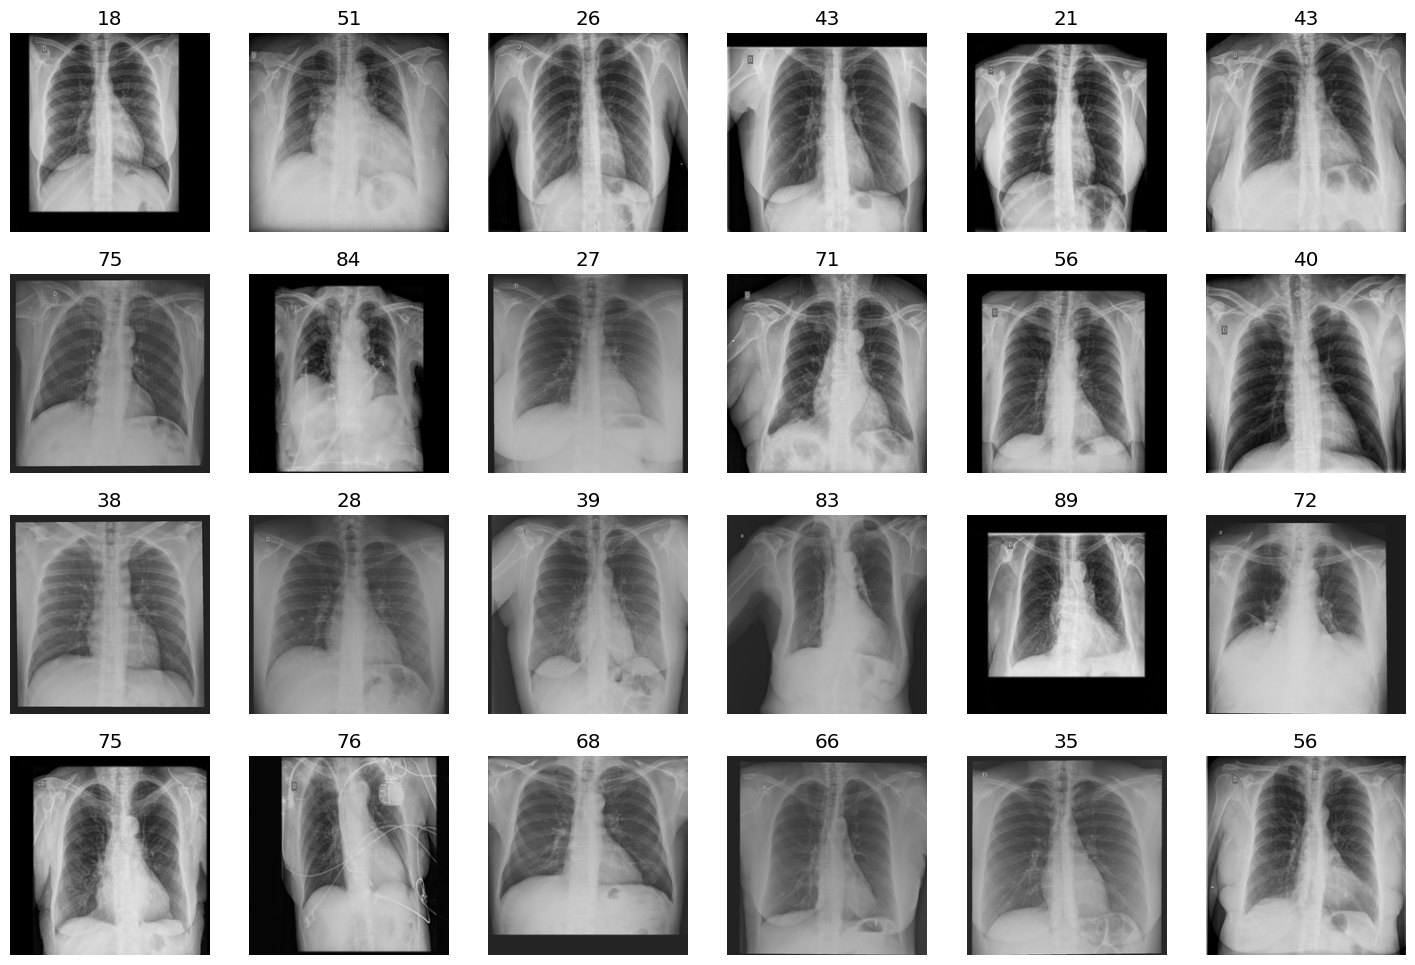

In [ ]:
# defines the image dataloader
dtblk = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = label_func,
)
dls = dtblk.dataloaders(train_path, bs = 32)

# shows some samples
dls.show_batch(max_n=24)

## <font color='blue'>3.1 Entrenamos todo ResNet50 _from scratch_, ajustando la cabecera para este problema.

El primer acercamiento que vamos a hacer es el de cambiar la cabecera (ahora se explica por qué) y entrenar todo el modelo desde 0, como hicimos en las partes anteriores de la práctica. Para ello, es necesario entender, al menos de manera básica, qué es ResNet50 y cómo funciona. De manera básica únicamente pues es un modelo que ya viene implementado en FastAI y solo tendremos que llamarlo.

$$$$

**¿Qué es ResNet50?**

ResNet50 es una red neuronal convolucional profunda que forma parte de la familia de ResNets (*Residual Networks*), diseñada en primera instanciad para resolver problemas de entrenamiento en redes profundas como el vanishing gradient. Fue introducida por Microsoft Research en 2015 en el paper "Deep Residual Learning for Image Recognition", [https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7780459].

<center><img src = https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png height = '300'></center>

En particular, ResNet50 tiene 50 capas ocultas. La principal característica de estas redes, y por tanto le da nombre a la red, es la introducción de bloques residuales. Estos bloques incluyen una conexión directa que **salta ciertas capas** y suma la entrada a la salida (ver esquema de la imagen de arriba).

El resto de la red está compuesta por capas que ya conocemos: convolucionales (algunas de reducción de dimensionalidad $1$ x $1$), ReLU, Batch Normalization, etc. La idea de esta red, de la cual nos aprovecharemos para esta práctica, sobre todo en el apartado de ajuste fino, es que las primeras capas y bloques convolucionales funcionan con **extractor de características**, para más tarde pasar a una parte clasificadora (FC + softmax).

$$$$

**📈Modificación necesaria para nuestro problema (regresión)**

ResNet50 está entrenada sobre un problema de clasificación, en concreto en un dataset con 1000 posibles clases de salida. Es por esto, que si queremos convertirla para tratar de resolver un problema de regresión, hemos de configurarla adecuadamente.

Lo único que necesitamos cambiar es la última capa FC, también conocida como **head**. Para ello, tal y como se explicó en prácticas, FastAI dispone de funcionalidades que permiten cambiar esta estructura sin modificar el resto de la red.

In [ ]:
from fastai.vision.all import *
resnet50().fc

Linear(in_features=2048, out_features=1000, bias=True)

Vemos que la red original tiene como entrada 2048 características, y 100 de salida, esto es, las clases de ImageNet. Además, revisando el paper original de la red residual, podemos comprobar qué dimensión tiene debe tener la imagen y el número de filtros usados en la última capa convolucional:

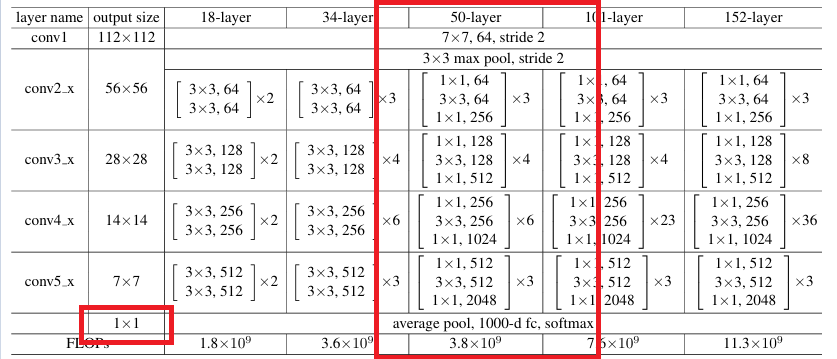



Conociendo todo esto, ya podemos pasar a la definición de nuestra nueva cabecera de la red. Veámos que forma tiene:

In [ ]:
custom_head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)),
    Flatten(),
    nn.Linear(2048, 1)
)

Modificaremos entonces:

* Añadimos una capa de AvgPool para que la salida de los bloques convolucionales pase a tener dimensión $1$ x $1$. A esto se le denomina **Global Average Pooling**.
* Hacemos flatten para poder gestionar y manejar correctamente las características extraídas.
* Usaremos una capa Fully Connected con tantas entradas como tiene ResNet50 (2048), y una **única neurona como salida**. Esta última neurona tendrá una función de activación lineal. Esto lo hacemos pues queremos predecir una única salida (edad predicha) para cada input. No es necesario tener más neuronas pues no tenemos distintas clases, si no una variable numérica a predecir para cada imagen.

Necesitamos que nuestra función de activación sea la función lineal o identidad. Para ello, por cómo funciona la capa `Linear`, **no hace falta usar ninguna función de activación**, pues el rango de valores puede ser $[-∞, ∞]$, que realmente es lo que buscamos pero en un rango de edades, claro.

<img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Ver [https://machinelearningmastery.com/building-a-regression-model-in-pytorch/]

$$$$

Algo que si debemos cambiar es la **función de pérdida**, así como las **métricas** usadas para evaluar el funcionamiento de la red, tal y como se nos indica en el enunciado.

En cuanto a las métricas, usaremos:

  * **Error cuadrático medio (MSE):** Es el más ampliamente usado para problemas de regresión y calcula el promedio de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales.

  $$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2$$

  * **Error absoluto medio (MAE):** Calcula el promedio de las diferencias absolutas entre las predicciones del modelo y los valores reales. El MAE proporciona una medida de la magnitud promedio de los errores del modelo y es menos sensible a valores atípicos que el MSE.

  $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$$

  * **Coeficiente de determinación ($R^2$):** Mide la proporción de la varianza en la variable dependiente que es explicada por el modelo. Un valor de $R^2$ cercano a 1 indica que el modelo explica bien la variabilidad de los datos, mientras que un valor cercano a 0 indica que el modelo no explica nada de la variabilidad.

  $$R^2 = 1 - \frac{\sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}{\sum_{i=1}^{n} \left( y_i - \bar{y} \right)^2}$$

\
<img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Todas estas están implementadas, ver [https://docs.fast.ai/metrics.html#regression]

$$$$

En cuanto a la **función de pérdida**, típicamente en los problemas de regresión se suele usar el MSE, explicado anteriormente. La diferencia a nivel de código radica en si llamamos a `MSELossFlat` o `mse`. Vamos a importar la función de pérdida y también las métricas que utilizaremos:





In [ ]:
from fastai.losses import MSELossFlat
from fastai.metrics import mse, mae, R2Score

loss_func = MSELossFlat()

<img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Cabe mencionar que todo lo explicado con anterioridad vale para el resto de la práctica, pues el problema será el mismo. Lo único que vamos a ir cambiando es qué parte de la red entrenamos y no, pero el proceso de entrenamiento es el mismo para los tres casos.

$$$$

Ahora que tenemos claro métricas, función de pérdida y la cabecera definida, podemos pasar a crear el objeto `vision_learner`, que es el que mediante ciertos parámetros (ahora explicados), nos permitirá crear y más tarde entrenar la red que queremos.

In [ ]:
learn = vision_learner(dls, resnet50, loss_func = loss_func, metrics = [mse, mae, R2Score()], pretrained = False,
                      custom_head = custom_head, train_bn = True)

**Parámetros que necesitamos modificar**

* `custom_head`: Nos permite modificar el *head* del modelo original.
* `pretrained`: Indica si se han de usar o no los parámetros ya entrenados del modelo. Evidentemente, si queremos entrenar de cero nuestra arquitectura, este parámetro debe ser **False**.
* `train_bn`: Establece si se han de entrenar o no las capas de Batch Normalization. Para este apartado lo estableceremos en True, aunque por defecto está a True.

Podemos pasar entonces al entrenamiento de la red. Usaremos para todos los casos posteriores un entrenamiento similar.

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

Vemos que en total nos quedamos con más de 23 millones de pesos, todos ellos entrenables. La red original para clasificación cuenta con unos 25 millones de parámetros.

Ahora que ya tenemos nuestra nueva red, con todos los pesos entrenables y modificada para el problema de regresión que nos atañe, podemos pasar al entrenamiento de la red. Usaremos el mismo método que usábamos en la anterior parte de la práctica, pero ahora entrenaremos, por cuestiones computacionales y de recursos, únicamente por **10 épocas**:

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.0020892962347716093


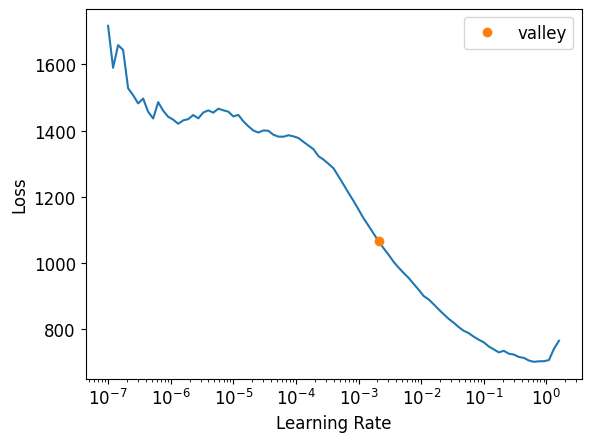

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

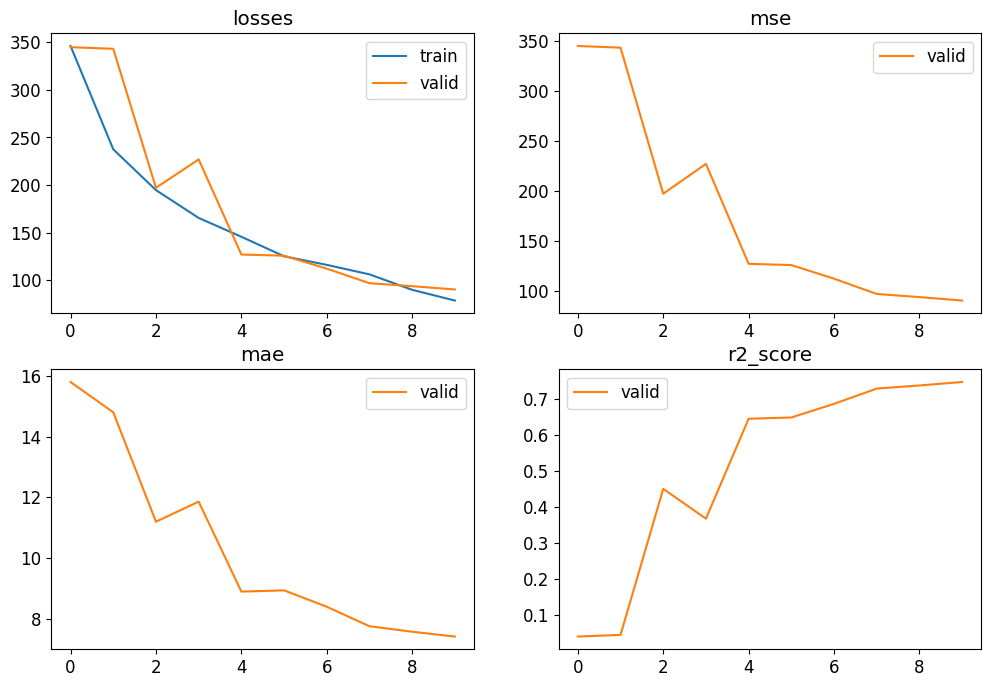

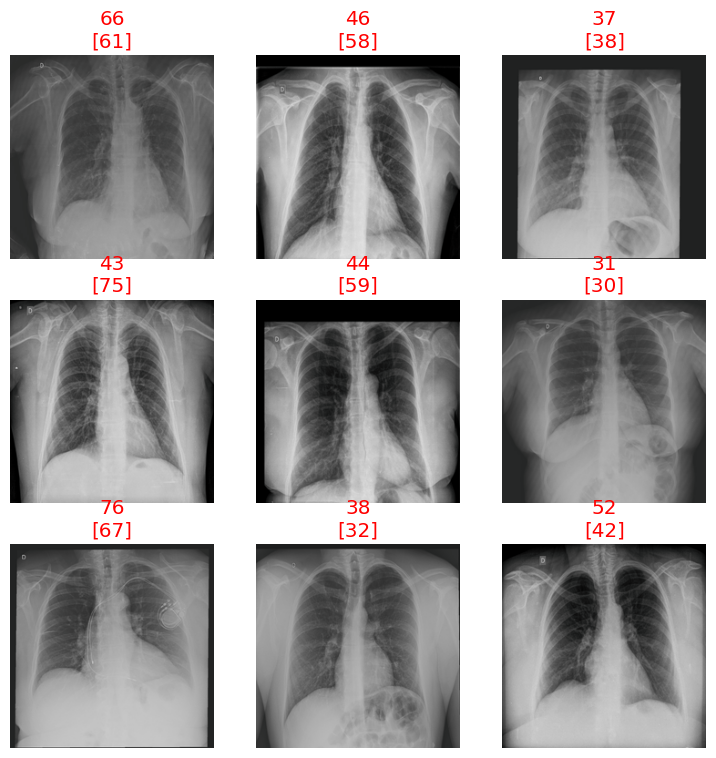

In [ ]:
learn.fit_one_cycle(n_epoch = 10, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

De las curvas de aprendizaje anteriores vemos que se realiza un buen entrenamiento. Parece no haber mucho sobreajuste y la pendiente es razonablemente buena. Sin embargo, parece que la capacidad de la red no mejora demasiado a partir de las últimas épocas. Veámos resultados para **entrenamiento y validación**:

The train mse is :  70.2032470703125
The train mae is :  6.567697048187256
The train r2 score is :  0.7938925623893738


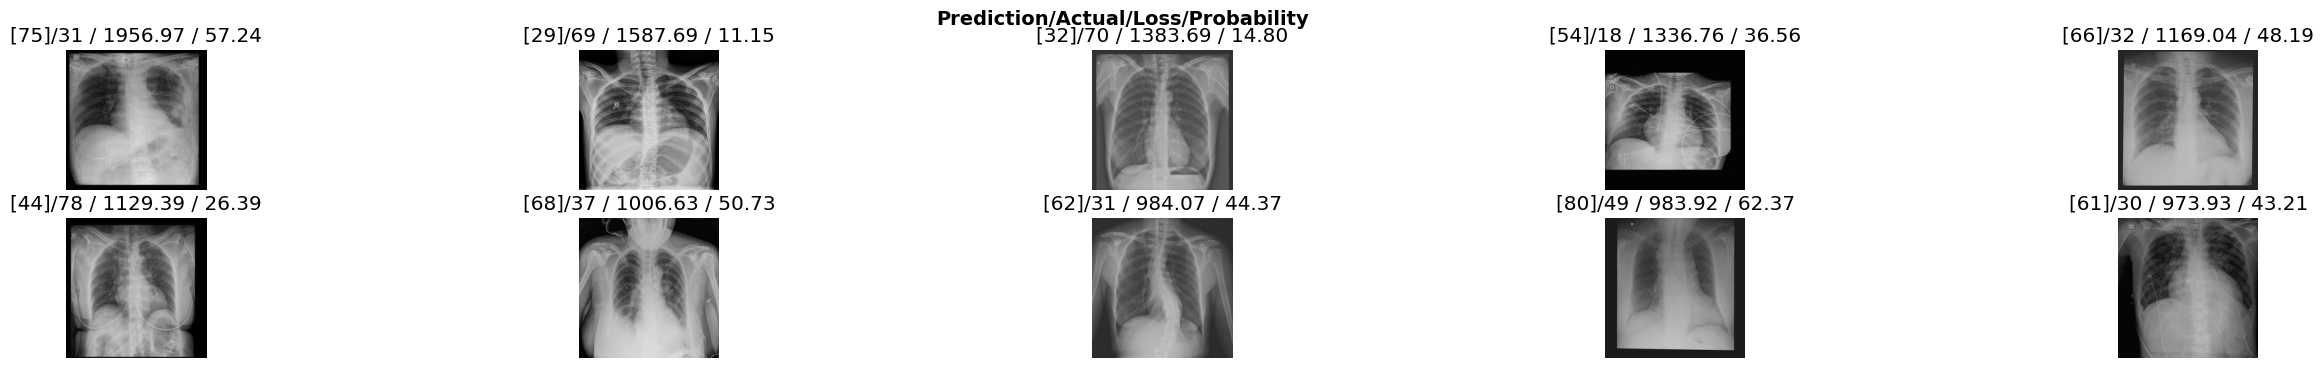

In [ ]:
interp_train = Interpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The train mse is : ', float(mse_score))
print('The train mae is : ', float(mae_score))
print('The train r2 score is : ', r2_score)

El modelo es bastante bueno, ya que un **$R^2$ de 0.79** sugiere que logra capturar una parte importante de la variabilidad de los datos. Sin embargo, hay margen para mejorar: un **MSE de 70.2** y un **MAE de 6.57** muestran que aún existen errores significativos en las predicciones. Veámos en validación:

The valid mse is :  90.2439956665039
The valid mae is :  7.418802261352539
The valid r2 score is :  0.7485052943229675


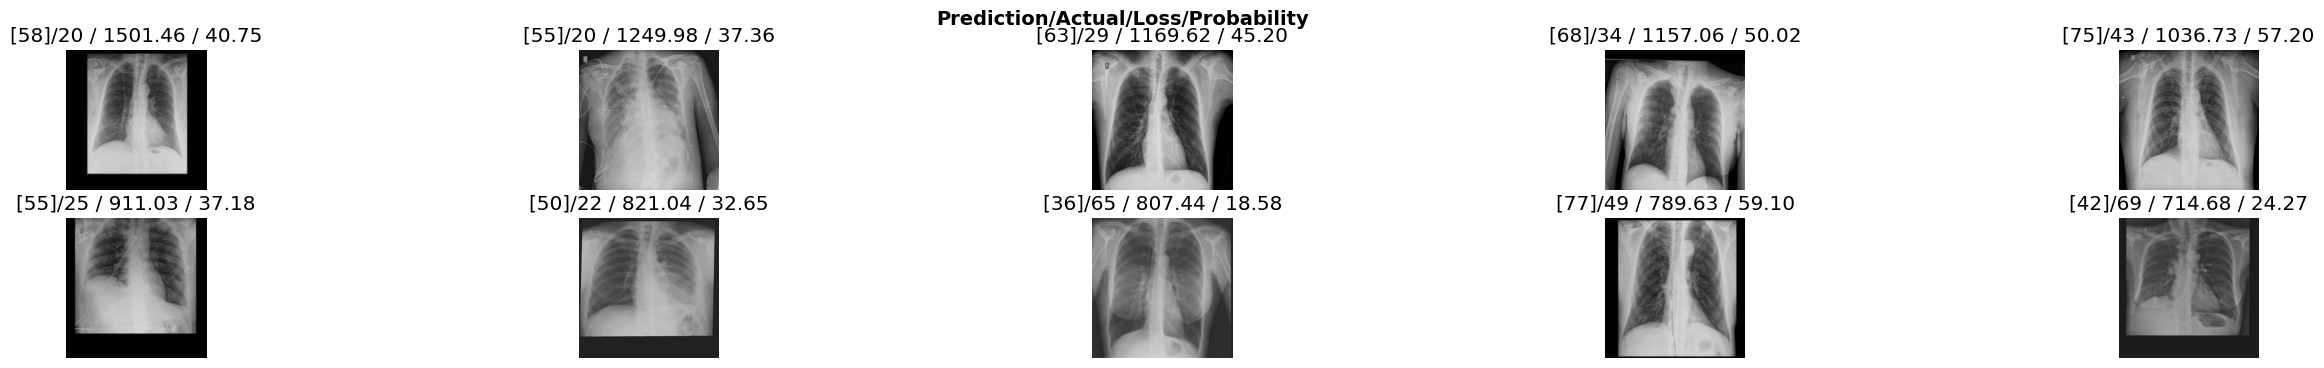

In [ ]:
interp_valid = Interpretation.from_learner(learn, 1,dls.valid)
interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The valid mse is : ', float(mse_score))
print('The valid mae is : ', float(mae_score))
print('The valid r2 score is : ', r2_score)

**📊Resultados y análisis**

Los resultados en validación son bastante parecidos a los obtenidos en entrenamiento, lo cual pone de manifiesto la calidad del modelo que estamos usando. Aún así, como ya se ha mencionado, **todavía cabe mejora** sobre los resultados, pues los errores no son demasiado bajos. Vamos entonces con los siguientes acercamientos al problema, pues ya tenemos una base para comparar.

Además, el entrenamiento no ha sido demasiado rápido, pues la red tiene un número bastante alto de parámetros a entrenar, como hemos visto. Esto nos lleva a pensar en lo que se comentaba sobre el **transfer learning**, pues una clara ventaja de esta técnica es el acelerar el entrenamiento, pues partimos de una base mucho más sólida. Lo veremos en el último apartado, 3.4.

## <font color='blue'>3.2. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada.



La idea ahora es la de usar los pesos que ya se han entrenado en ResNet50, para el conjunto de imágenes ImageNet. Como hemos discutido varias veces en clase, existe una clara separación en dos partes en una red convolucional estándar:

* **Bloques convolucionales**: Extractores de características. Al ir aprendiendo los pesos de los filtros y aplicando transformaciones a la entrada de la red, somos capaces de extraer características de la misma.

* **Fully Connected**: Parte clasificadora. A partir de las características extraídas en la parte anterior de la red, se procede a la clasificación de imágenes.

**Es por esto que podemos reutilizar la parte extractora de característica de una red que ya ha sido reentrenada. Ahora la parte clasificadora consistirá en una regresión realmente, pero la extracción previa de características la podemos hacer en base al conocimiento que ya tiene la red.**

Como ya conocemos como funciona la cabecera que hemos implemetado, ahora es tan sencillo como cambiar dos parámetros del `Learner`. Ahora, como se nos indica, solo tenemos que entrenar la cabecera que hemos incorporado. Por tanto, redefinimos:

In [ ]:
learn = vision_learner(dls, resnet50, loss_func = loss_func, metrics = [mse, mae, R2Score()], pretrained = True,
                      custom_head = custom_head, train_bn = False)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Lo que aparece en la salida de la ejecución de la celda anterior es el resultado de descargar los pesos de la red preentrenados.

Solo hemos cambiado:

* `pretrained`: Ahora está a **True**, pues vamos a usar los pesos preentrenados de ResNet50.
* `train_bn`: Queremos entrenar únicamente la nueva cabecera. Congelamos TODOS los pesos de la red anteriores, incluidos los de Batch Normalization.

Como ya hemos comentado a lo largo de la práctica, gracias a las funcionalidades que nos proporciona una librería de tan alto nivel como es *FastAI*, basta con cambiar los parámetros mencionados para que, internamente, se llame a `learner.freeze()` y `learner.unfreeze()`. Estas funciones congelan y descongelan los gradientes durante el entrenamiento, de manera que los pesos no se actualizan. Por tanto, al usar `pretrained = True`, todos los peso, **salvo los de la cabecera**, se congelan, y por tanto, en el entrenamiento solo se hará actualización de estos pesos. Serán nuestros **total trainable params**, en la salida de `summary()`.

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

El entrenamiento ahora será mucho más sencillo: pasamos de tener más de 23 millones de parámetros entrenables, a tener **solo 2049**. Es la ventaja de contar con los pesos entrenados ya del modelo. Procedemos ahora entonces al entrenamiento, pues nada cambia en cuanto al mismo. La única diferencia ahora es que tenemos todos los **pesos congelados** de los bloques convolucionales:

Aproximación learning rate: 0.02754228748381138


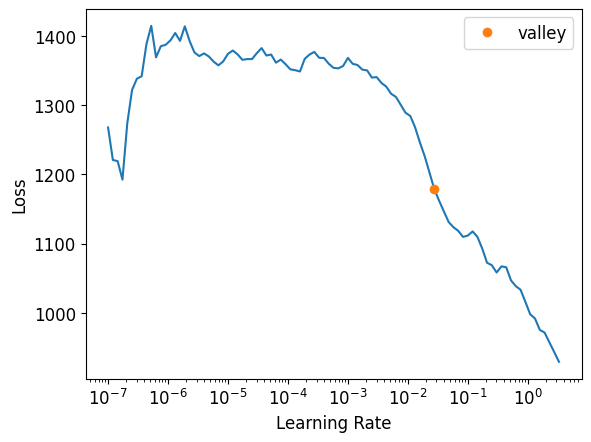

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

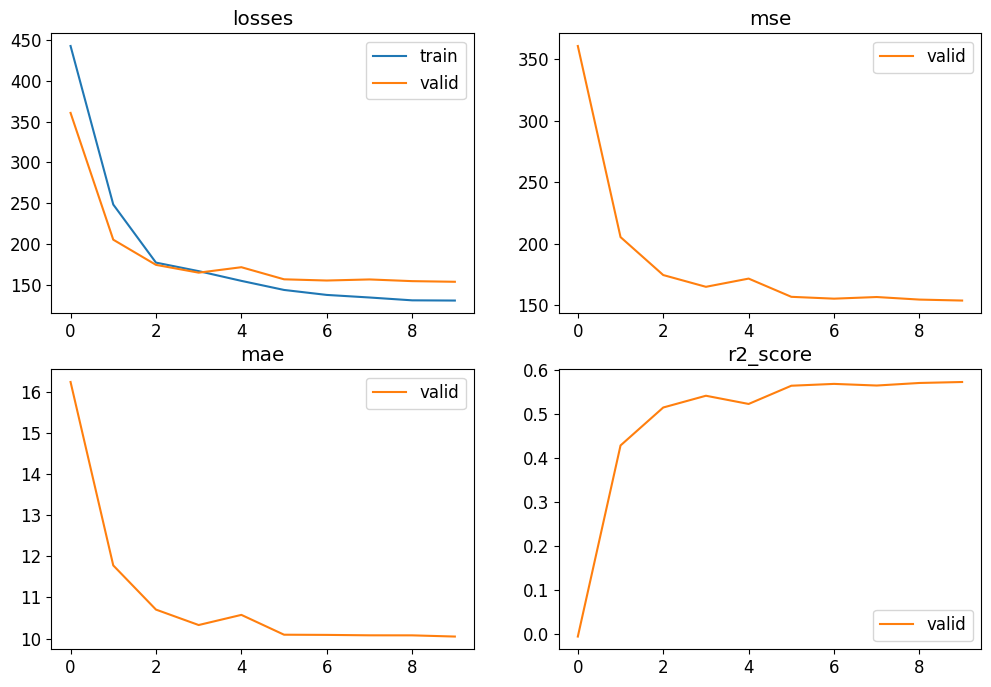

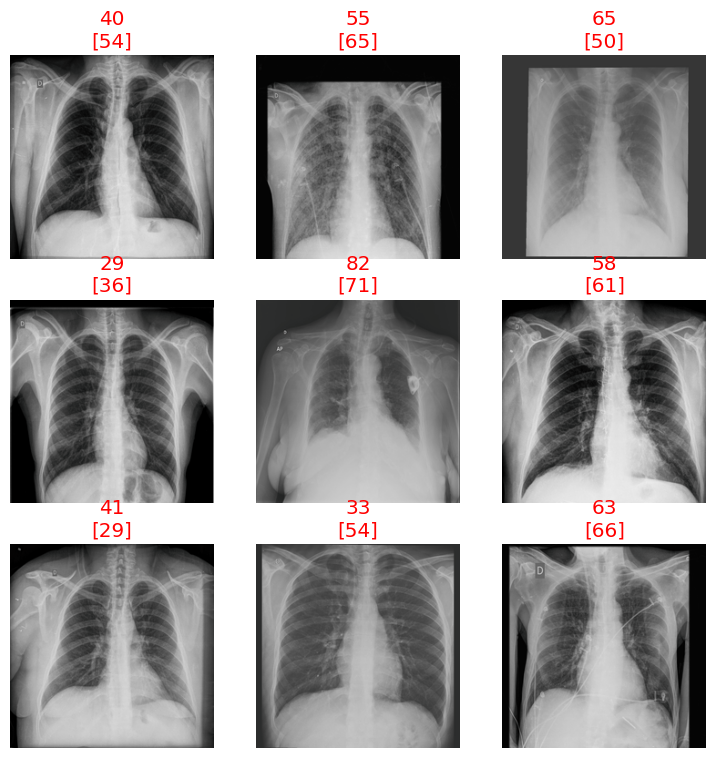

In [ ]:
learn.fit_one_cycle(n_epoch = 10, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train mse is :  120.40534973144531
The train mae is :  8.864446640014648
The train r2 score is :  0.6465058922767639


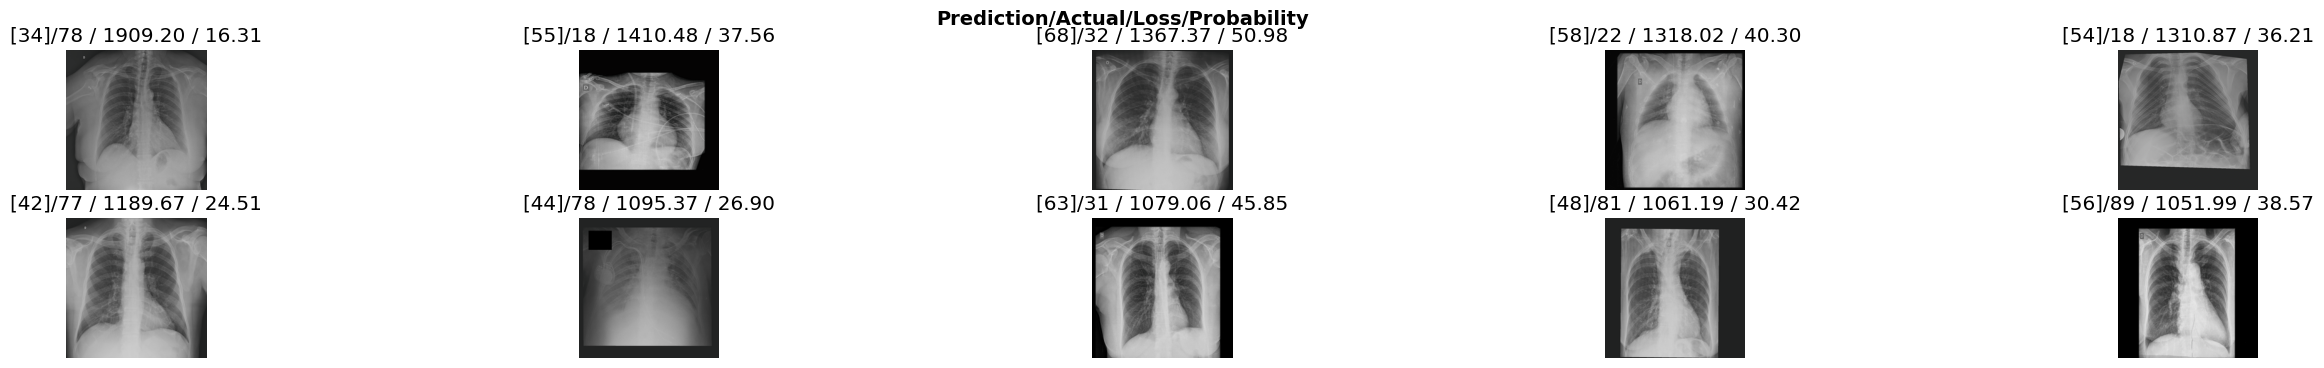

In [ ]:
interp_train = Interpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The train mse is : ', float(mse_score))
print('The train mae is : ', float(mae_score))
print('The train r2 score is : ', r2_score)

The valid mse is :  153.67645263671875
The valid mae is :  10.04787540435791
The valid r2 score is :  0.5717297792434692


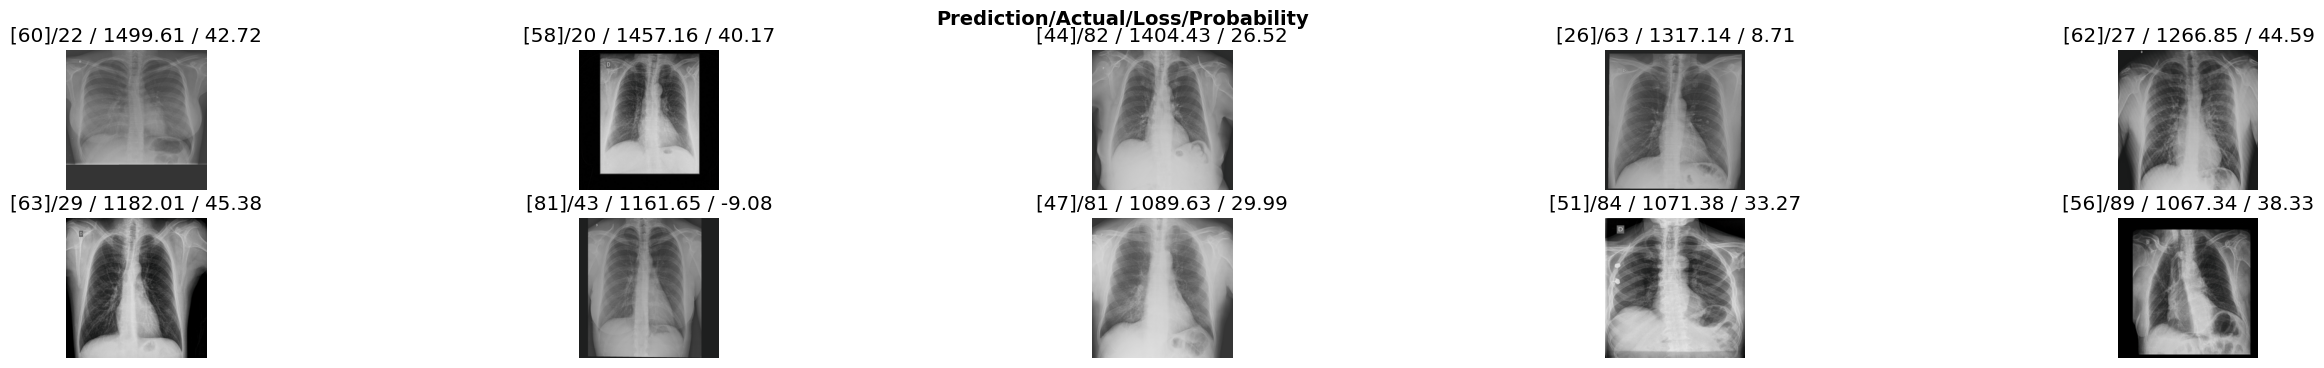

In [ ]:
interp_valid = Interpretation.from_learner(learn, 1,dls.valid)
interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The valid mse is : ', float(mse_score))
print('The valid mae is : ', float(mae_score))
print('The valid r2 score is : ', r2_score)

**📊Resultados y análisis**

Obtenemos resultados ligeramente peores que cuando entrenábamos la red entera desde cero. Pasamos a tener, en validación, un **$R^2$ de 0.57**, que sugiere que no consigue explicar demasiada variabilidad de los datos. Además, obtiene un **MSE de 153.67** y un **MAE de 10.05**, que es casi el doble de lo que teníamos previamente.

$$$$

La principal ventaja de emplear esta técnica, es que podemos aprovechar los pesos que tiene ResNet50 (entrenada sobre otro conjunto de datos), para convertir las imágenes en conocimiento. Esto es, sin actualizar ninguno de los pesos de la parte extractora de características, conseguimos para cada imagen un vector con distintos valores que serán nuestras features, con las que entrenamos nuestro modelo clasificador (nuestra cabecera *custom*).

**¿Qué limitaciones parece tener?**

Las curvas de aprendizaje son reveladoras, pues basta fijarse en cómo evoluciona la red para ver que el aprendizaje está totalmente limitado. Deja de mejorar pasado cierto número de épocas y esto suele significar underfitting y, por mucho que continúe el entrenamiento, no daría mejores resultados.

Podemos achacar esto al que la extracción de características realmente está entrenada sobre otro tipo de imágenes, y por tanto características que pudiesen ser muy relevantes para el entrenamiento de la red original, igual para estas muestras no lo son tanto, y estamos obviando otras más importantes para nuestro caso de estudio.

## <font color='blue'>3.3. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada por defecto por fastai.



Para este apartado, realmente no cambia mucho la estructura. Lo único que varía es el cómo definimos e implementamos la cabecera a entrenar, pero realmente el proceso de entrenamiento será el mismo.

Lo que podemos esperar para este caso son resultados muy similares que solo dependerán de las diferencias entre la cabecera custom que hemos creado nosotros y la que crea FastAI por defecto.

$$$$

**Revisión de la documentación aportada por el profesor**:

De la documentación oficial de FastAI y de lo aprendido de la creación y llamada de backbones (partes de extracción de características), se describe ahora cómo adaptar la cabecera creada por FastAI por defecto para nuestro problema:

* Llamada a `vision_learner`: Al llamar a esta función de creación del learner, la librería intenta adaptar la cabecera del modelo al conjunto de datos pasado como argumento.

> "The model is built from `arch` using the number of final activations inferred from `dls` if possible (otherwise pass a value to `n_out`)."

* Nos aseguramos de esto, usando el parámetro `n_out = 1`.

De esta manera, podemos asegurarnos haciendo lo descrito y llamando a `summary()`:

In [ ]:
learn = vision_learner(dls, resnet50, loss_func = loss_func, metrics = [mse, mae, R2Score()], pretrained = True,
                       n_out = 1 , train_bn = False)

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Podemos imprimir también la cabecera obtenida,

 **Cabecera incorporada por defecto para nuestro problema**:

In [ ]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=False)
)

Comprobamos que la cabecera añadida, es la que añade siempre por defecto la librería, salvo que como salida tendremos una única neurona, pues queremos que se adapte a nuestro problema como hacíamos en los apartados anteriores.

**Cabecera incoporada por defecto por fastAI (sin cambiar ningún parámetro):**

```
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=768, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)
```

> Cabecera añadida por defecto en FastAI. Extraído de [https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw ], y podemos ver que coincide con lo descrito en la celda anterior, salvo la última capa FC que tiene como `out_features = 1`.

Observamos también que el número de parámetros entrenables ha aumentado considerablemente, pues la cabecera que añade FastAI cuenta con más capas y pesos. Pasamos de tener 2049 pesos entrenables a tener **más de 2 millones**. Veremos ahora que impacto tiene esto en el entrenamiento de la cabecera solo, usando los pesos entrenados de la red.

$$$$

Una vez tenemos la arquitectura creada ya podemos proceder al entrenamiento, de igual manera que hacíamos en el apartado anterior:




/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.005248074419796467


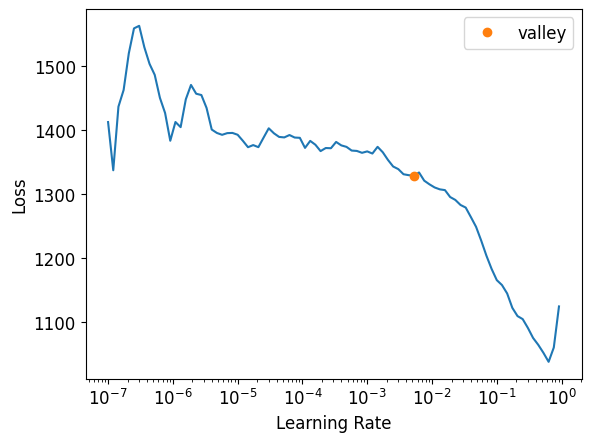

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

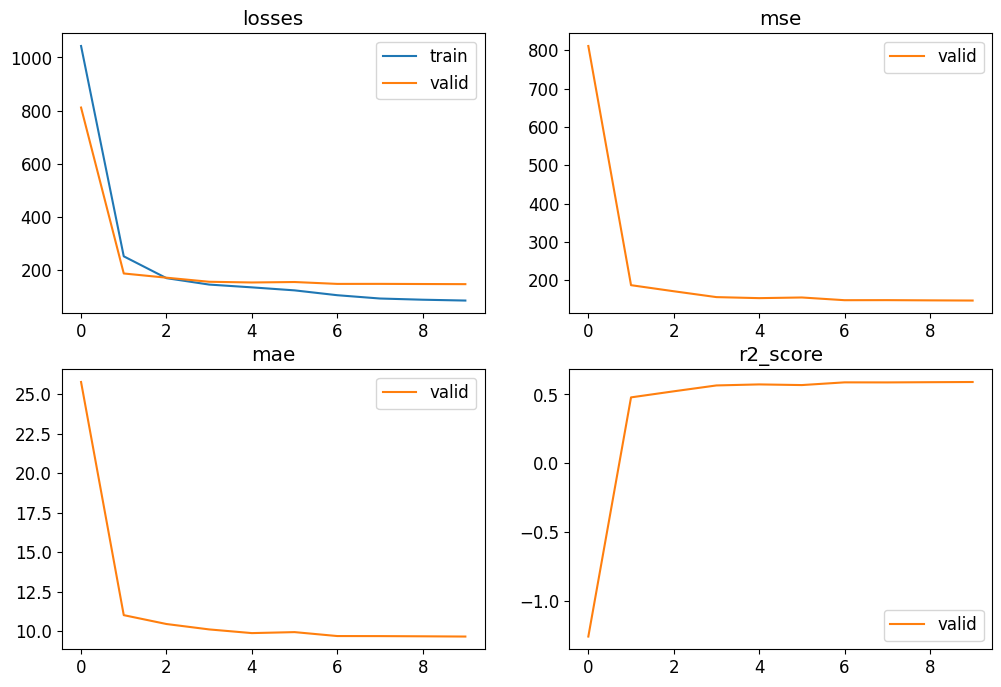

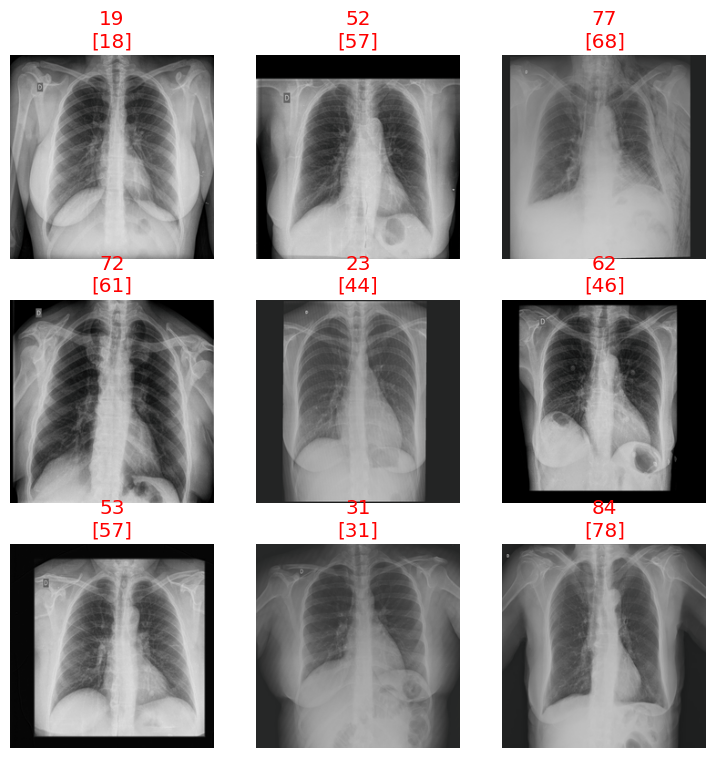

In [ ]:
learn.fit_one_cycle(n_epoch = 10, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train mse is :  40.906402587890625
The train mae is :  5.14243221282959
The train r2 score is :  0.8799042701721191


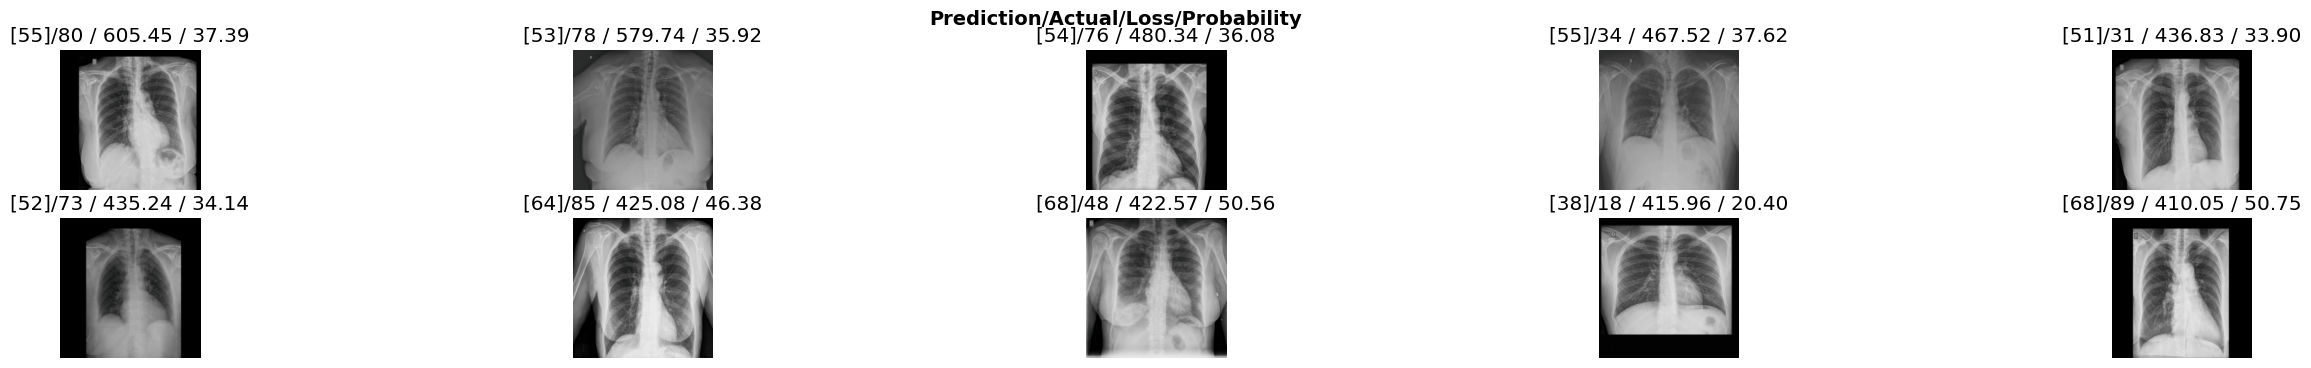

In [ ]:
interp_train = Interpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The train mse is : ', float(mse_score))
print('The train mae is : ', float(mae_score))
print('The train r2 score is : ', r2_score)

Obtenemos en entrenamiento un **$R^2$ de 0.87**, un **MSE de 40.91** y un **MAE de 5.14**.

The valid mse is :  146.8006591796875
The valid mae is :  9.667820930480957
The valid r2 score is :  0.5908914804458618


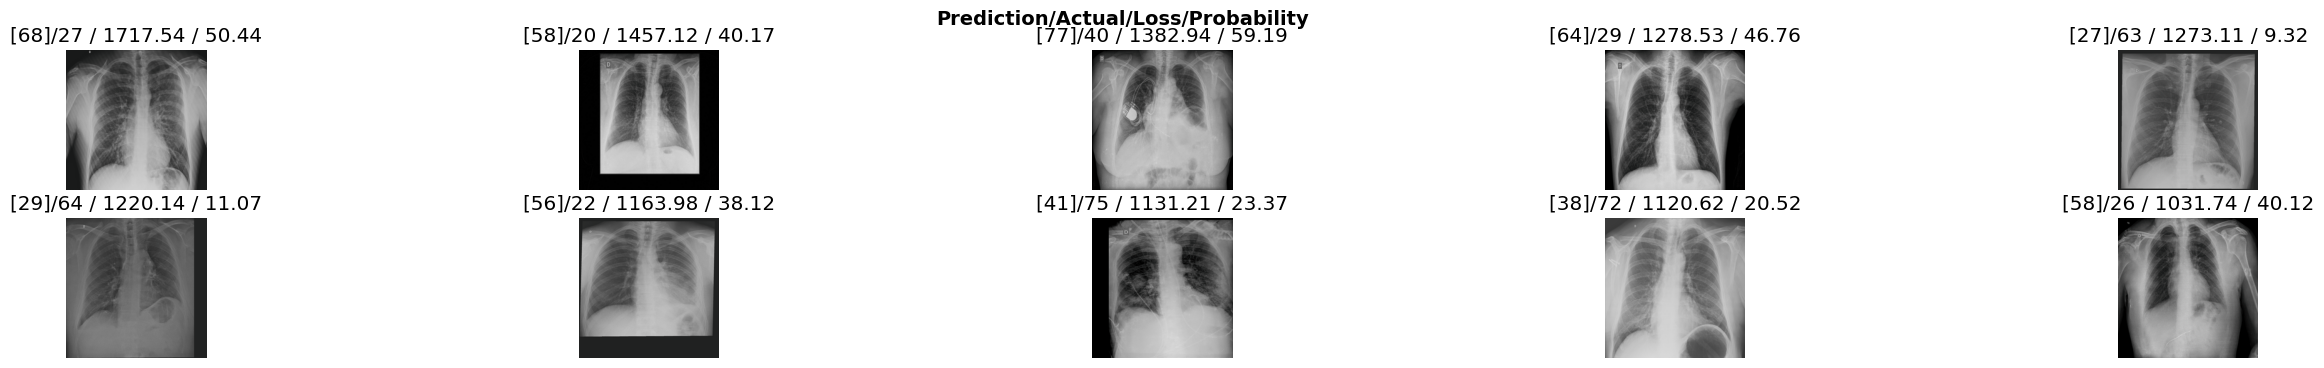

In [ ]:
interp_valid = Interpretation.from_learner(learn, 1,dls.valid)
interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The valid mse is : ', float(mse_score))
print('The valid mae is : ', float(mae_score))
print('The valid r2 score is : ', r2_score)

**📊Resultados y análisis**

Los resultados obtenidos para validación son bastante similares que para el caso anterior, en que usábamos nuestra propia cabecera. Obtenemos un **$R^2$ de 0.59**, que sugiere, de nuevo, que no consigue explicar demasiada variabilidad de los datos. Además, obtiene un **MSE de 146.80** y un **MAE de 10.05**, que si lo comparamos con el entrenamiento desde cero, también es bastante mayor.

Se observa un poco de sobreajuste en el entrenamiento pero hemos mejorado ligeramente los resultados en validación. Esto tiene sentido hemos discutido el aumento de parámetros a entrenar.

Se observa también el fenómeno que teníamos para el apartado anterior; existe **una clara limitación** de la red para aprender, y de nuevo podemos explicarlo de la misma manera. Las características extraídas por ResNet50, por muy buenas que fuesen para el conjunto de datos donde fueron entrenadas, ahora puede ser que no sean de tan buena calidad. Esto motiva el último apartado.

## <font color='blue'>3.4. Hacemos un ajuste fino (fine-tuning) de toda la red partiendo de los pesos de ImageNet.

Habiendo experimentado en los apartados anteriores con los distintos enfoques para entrenar sobre un nuevo dataset, ahora vamos con el que es, bajo mi punto de vista, el que obtendrá mejores resultados y el mejor de los métodos a seguir en casos como este.

Para ello, ahora no vamos a congelar ninguno de los pesos entrenados. Sí que es cierto que el parámetro `pretrained` lo dejaremos a `True`, pues vamos a necesitar que los pesos estén inicializados. Además, `train_bn` también estará a `True`, pues vamos a reentrenarlos:

In [ ]:
learn = vision_learner(dls, resnet50, loss_func = loss_func, metrics = [mse, mae, R2Score()], pretrained = True,
                       custom_head = custom_head, train_bn = True)

> También usaremos la cabecera implementada por nosotros (apartado 3.2), pues considero que es más simple y puede dar lugar a menor overfitting, pues el número de parámetros es bastante menor. Además, ya nos proporcionó buenos resultadsos en el apartado primero.

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Inicialmente el summary nos muestra que únicamente tenemos alrededor de 55 mil pesos entrenables, de los más de 23 millones que tiene la red. Esto será así únicamente para la primera época. La gran diferencia ahora es que sí que vamos a actualizar el resto de pesos, para ello haremos uso del conocido **Fine Tuning**.

$$$$

**🧠 Fine tuning y cómo implementarlo en FastAI**

El **fine-tuning** es una técnica de entrenamiento en Deep Learning que consiste en ajustar un modelo preentrenado (normalmente entrenado en un conjunto de datos grande, como ImageNet en nuestro caso) para resolver una tarea específica con nuestros propios datos. *FastAI* facilita mucho este proceso, implementando prácticas de entrenamiento con pocas líneas de código. Basta una simple llamada a `fine_tune`:

1. Entrena la cabecera durante 1 época (`freeze_epochs` por defecto a 1).
2. Descongela gradualmente; luego descongela todas las capas y entrena el modelo completo durante el número de épocas que especifiquemos (pondremos `epochs = 10`). Utiliza además **discriminative learning rate** (tasas de aprendizaje diferentes para cada capa). Esto es:
 - Capas profundas (cercanas a la entrada) tienen tasas de aprendizaje más bajas.
  - Capas cercanas a la salida tienen tasas más altas.

<center><img src = https://blent-static-media.s3.eu-west-3.amazonaws.com/photos/blog/llm_finetuning.png height = '300'></center>

Al entrenar la cabecera durante una época, permitimos que la red haga un ajuste rápido inicial, adaptando los pesos de la cabecera a las características específicas del nuevo problema.

Conseguimos de esta forma adaptar una red que se ha entrenado sobre datos de otro problema para el nuestro en específico.

> Explicación de parámetros en la documentación oficial [https://docs.fast.ai/vision.learner.html#learner-convenience-functions]

Para el *learning rate* como parámetro de `fine_tune()`, debemos tener en cuenta que internamente este método llama `fit_one_cycle()`, y para ello, como se discutió en el ejercicio anterior, se ha de estimar un cierto *lr* con `lr_find()`. Sin embargo, de esto ya se encarga la propia librería. Lo que sí que podemos hacer es dar un *learning rate* de base, `base_lr`, sobre el que el método se encargará de ir derivando las distintas tasas de aprendizaje sobre cada una de las capas.

Por tanto, para dar esta tasa de aprendizaje base considero el tomar la estimación de `lr_find()` como tasa base para que el modelo tenga un punto de partida decente. Vamos a encontrar este *learning rate* y procedemos al **fine-tuning**:


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.013182567432522774


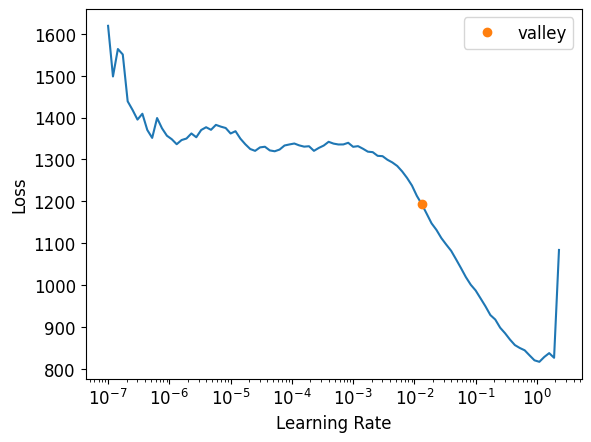

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

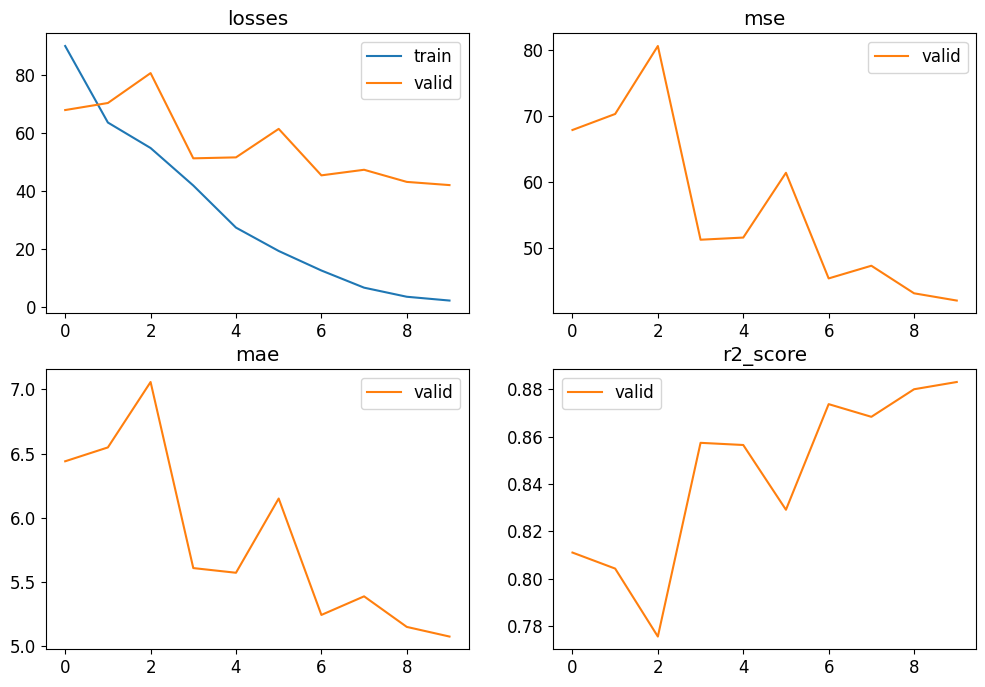

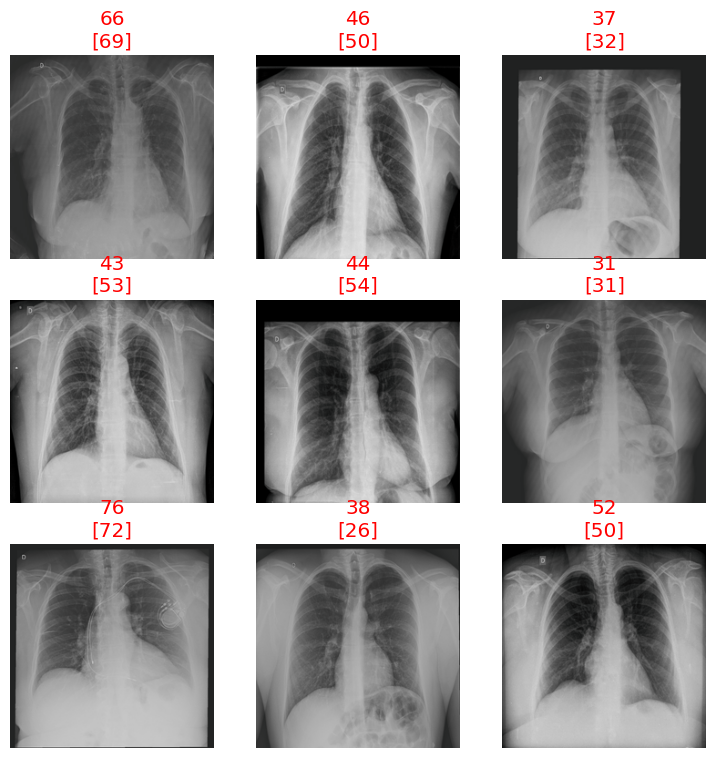

In [ ]:
learn.fine_tune(epochs = 10, base_lr = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train mse is :  0.923732578754425
The train mae is :  0.7288509011268616
The train r2 score is :  0.9972880482673645


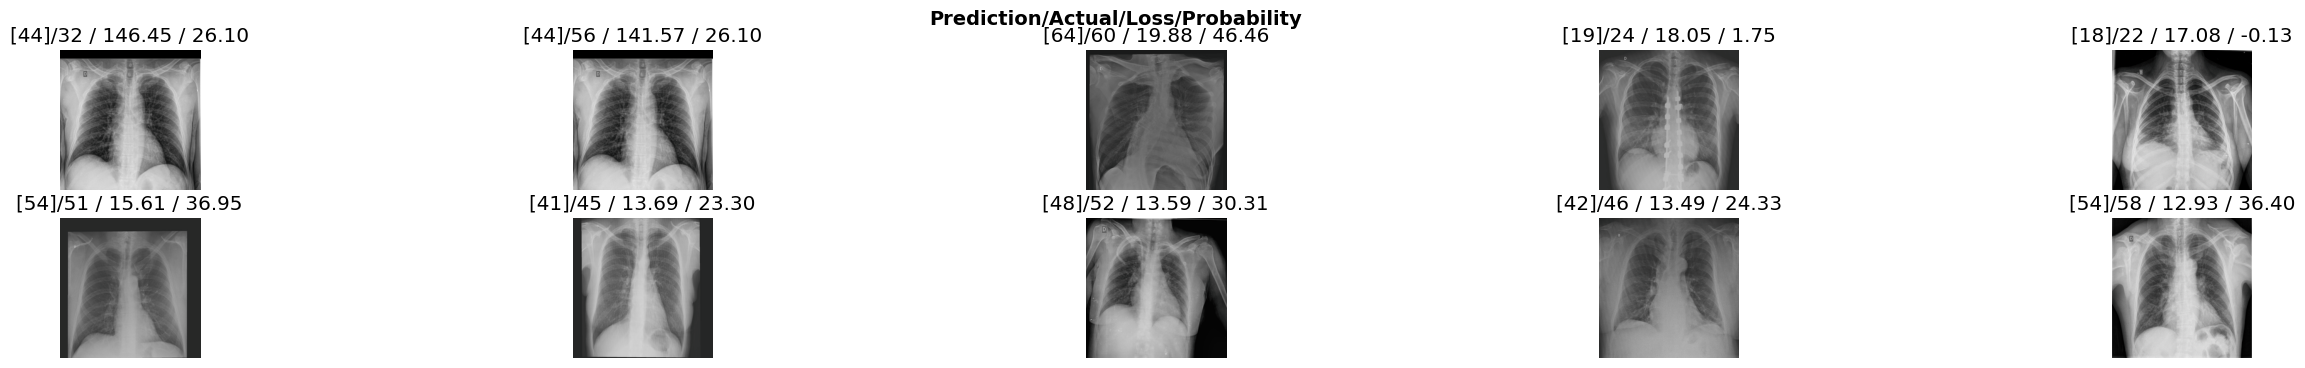

In [ ]:
interp_train = Interpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The train mse is : ', float(mse_score))
print('The train mae is : ', float(mae_score))
print('The train r2 score is : ', r2_score)

The valid mse is :  41.97062683105469
The valid mae is :  5.073625087738037
The valid r2 score is :  0.8830350041389465


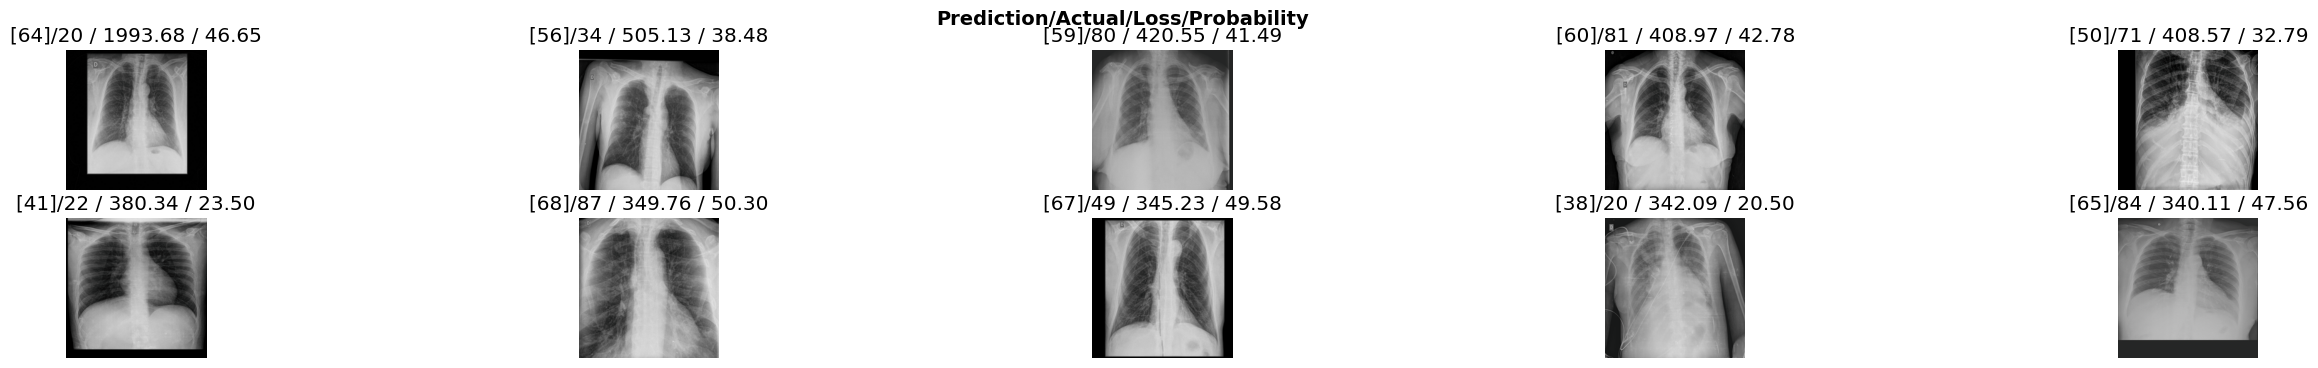

In [ ]:
interp_valid = Interpretation.from_learner(learn, 1,dls.valid)
interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The valid mse is : ', float(mse_score))
print('The valid mae is : ', float(mae_score))
print('The valid r2 score is : ', r2_score)

**📊Resultados y análisis**

Vemos que ahora obtenemos unos muy buenos resultados, acercádonos al **1.00 de $R^2$** en entrenamiento y generalizando aparentemente bien pues tenemos cerca del **0.89** para validación, además de errores cuádratico medio y absoluto bastante más bajos que para los modelos anteriores. Se discutirá en las conclusiones pero parece ser que este acercamiento al problema ofrece resultados mucho mejores.

$$$$

**Inferencia en test**

Ahora que ya conocemos el funcionamiento de todas las redes podemos ver cómo se comporta este último (lo hacemos para este pues ha dado los mejores resultados) en el conjunto de test, que si recordamos se trataba de un conjunto de 4000 radiografías que no han sido usadas para el entrenamiento.

The valid mse is :  35.62507629394531
The valid mae is :  4.666750431060791
The valid r2 score is :  0.9075998067855835


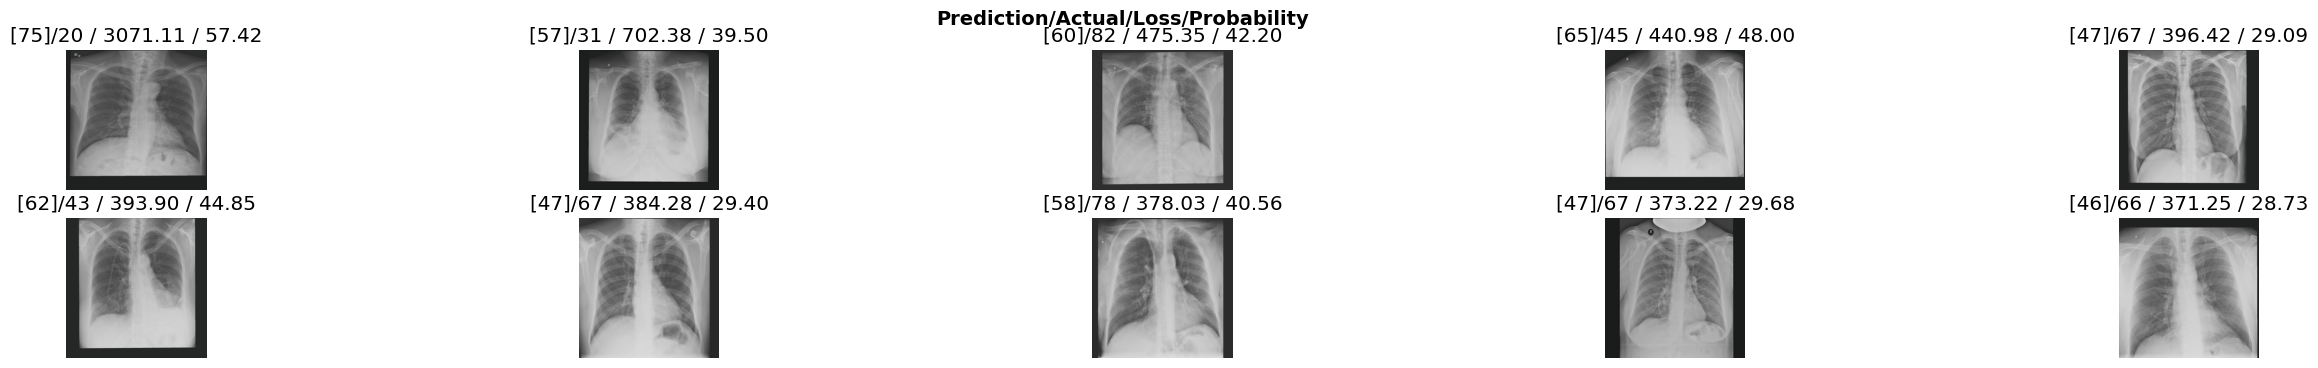

In [ ]:
test_dl = learn.dls.test_dl(test_files,with_labels=True)
interp_test = Interpretation.from_learner(learn, 1,test_dl)
interp_test.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)

mse_score = mse(preds, targs)
mae_score  = mae(preds,targs)
r2_score = R2Score()(preds, targs)
print('The valid mse is : ', float(mse_score))
print('The valid mae is : ', float(mae_score))
print('The valid r2 score is : ', r2_score)

Concluimos que el resultado ha sido bastante satisfactorio pues se explica algo más del $90\%$ de la variabilidad del conjunto de datos y hemos conseguido unos errores bastante reducidos. En general, un resultado de estas características, con estos valores para las métricas suele indicar una muy buena calidad de aprendizaje para el modelo. En este caso, el combinar un modelo de alto calibre como es **ResNet50** con una técnica de transfer learning como es **fine-tuning**, ha resultado ser muy útil.

## <font color='blue'>Conclusiones. ¿Qué conclusiones se pueden extraer en base a toda la experimentación anterior? En caso de que nos enfrentemos a un nuevo problema, ¿qué opción, u opciones, de entre las anteriores, parece a priori la más razonable? ¿Por qué?

En primer lugar, hagamos síntesis de los resultados y los distintos modelos que hemos entrenado, mostrando las métricas para cada uno:

$$$$

**📊 Tabla de resultados - Entrenamiento**

| Modelo       | MSE        | MAE        | R²        |
|--------------|------------|------------|-----------|
| **Apartado 3.1**   | 70.20      | 6.567      | 0.79    |
| **Apartado 3.2**   | 120.405      | 8.86      | 0.646    |
| **Apartado 3.3**   | 40.906      | 5.142      | 0.879    |
| **Apartado 3.4**   | 0.923      | 0.728      | 0.997    |

$$$$

**📊 Tabla de resultados - Validación**

| Modelo       | MSE        | MAE        | R²        |
|--------------|------------|------------|-----------|
| **Apartado 3.1**   | 90.24      | 7.42     | 0.748    |
| **Apartado 3.2**   | 153.676      | 10.047      | 0.57    |
| **Apartado 3.3**   | 146.80      | 9.667      | 0.59    |
| **Apartado 3.4**   | 41.97      | 5.07      | 0.883    |

$$$$

**¿Qué analizamos para cada modelo/técnica empleado?**

* **Apartado 3.1** El entrenamiento desde cero ajusta todos los pesos de ResNet50 sin usar pesos preentrenados.
Aunque el modelo alcanza un $R^2$ aceptable tanto en entrenamiento como en validación, los errores aún son elevados (MSE y MAE). Esto indica que entrenar una red tan compleja desde cero puede llevar a una convergencia más lenta y a un ajuste menos preciso.

* **Apartado 3.2** El rendimiento es bastante pobre en comparación con otros métodos, con un $R^2$ bajo y errores elevados.Esto sugiere que las características extraídas por las capas preentrenadas no son suficientes para resolver este problema específico. La cabecera ajustada no logra adaptarse del todo a los datos.

* **Apartado 3.3** El rendimiento en entrenamiento es mucho mejor que en el apartado 3.2, con un MSE y MAE más bajos y un $R^2$ superior (0.879). Sin embargo, la validación muestra **overfitting**. El modelo generaliza peor, lo que se refleja en el incremento del MSE y la disminución del $R^2$ (0.59).

* **Apartado 3.4** Los resultados son notablemente mejores tanto en entrenamiento como en validación:
  * Un $R^2$ de 0.997 en entrenamiento indica que el modelo ajusta perfectamente los datos de entrenamiento.
  * La validación también alcanza un $R^2$ alto (0.883) y errores significativamente más bajos.

  Esto demuestra que el **fine-tuning** de toda la red logra extraer características más relevantes para el problema, adaptando la red de manera óptima para nuestro problema específico.

Todo esto respalda que ante un problema nuevo, la opción, a priori, más razonable es la seguida en el apartado **3.4**.

**El fine-tuning ha demostrado, al menos para este caso, ser un buen acercamiento, pues permite convertir la extracción de características a un proceso más refinado, al mismo tiempo que aprovecha el conocimiento previo aprendido por ResNet50.**

En cuanto a preferibilidad, el siguiente enfoque a escoger sería el de entrenar desde cero. Claro está, que esta vía es solo recomendable si contamos con capacidad computacional suficiente.

Por último, si los recursos computacionales o el tiempo son limitados, ajustar solo la cabecera puede ser una buena estrategia inicial. Es rápido y aprovecha los pesos preentrenados de las capas preentrenadas.

$$$$
**¿Qué se ha aprendido del ejercicio?**
Todos los resultados anteriores respaldan que:

* En general, es preferible partir de conocimiento previo para hacer fine-tuning a nuestros modelos, si sabemos que el modelo preentrenado es de buena calidad.

* La extracción de características de un modelo preentrenado está limitada al conjunto de datos en que se entrenó. Es lo que se puede observar con claridad en las curvas de aprendizaje de los apartados 3.2 y 3.3.

* Entrenar desde cero solo se recomienda si el problema es muy específico y contamos con grandes volúmenes de datos y recursos.